In [284]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [291]:
exps = ["output_q=0.1_a=0.9_p=0"]
exp_name = ["test"]
figsize = (10,4)
#"10q80p", "10q90p", "10q95p","20q80p", "20q90p", "20q95p",

In [292]:
data = [f"{exp}/timeQueries/influx/" for exp in exps]
names = os.listdir(os.path.join(data[0]))
if '.DS_Store' in names: names.remove('.DS_Store')
runs = list(np.sort(os.listdir(os.path.join(data[0], names[0]))))
if '.DS_Store' in runs: runs.remove('.DS_Store')
results = ["ttiMinMaxResults", "m4Results"]
labels = ["VS Cache", "M4"]
data, results, runs, names

(['output_q=0.1_a=0.9_p=0/timeQueries/influx/'],
 ['ttiMinMaxResults', 'm4Results'],
 ['run_0'],
 ['soccer_exp', 'manufacturing_exp', 'intel_lab_exp'])

In [293]:
results_paths = [os.path.join(d, name, run, result) for d in data for name in names for result in results for run in runs  ]
results_paths

['output_q=0.1_a=0.9_p=0/timeQueries/influx/soccer_exp/run_0/ttiMinMaxResults',
 'output_q=0.1_a=0.9_p=0/timeQueries/influx/soccer_exp/run_0/m4Results',
 'output_q=0.1_a=0.9_p=0/timeQueries/influx/manufacturing_exp/run_0/ttiMinMaxResults',
 'output_q=0.1_a=0.9_p=0/timeQueries/influx/manufacturing_exp/run_0/m4Results',
 'output_q=0.1_a=0.9_p=0/timeQueries/influx/intel_lab_exp/run_0/ttiMinMaxResults',
 'output_q=0.1_a=0.9_p=0/timeQueries/influx/intel_lab_exp/run_0/m4Results']

In [294]:
dcts = [{
    'IO Count': 'mean',
    'Time (sec)': 'mean',
    'Memory': 'mean',
    'query #': 'mean',
    'width' : 'mean',
    'height' : 'mean',
    'timeRange': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'from': 'mean',
    'to': 'mean',
    'Results size': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'Error': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'dataset': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'operation': lambda col: col.mode() if col.nunique() == 1 else np.nan
}, 
    {
    'Time (sec)': 'mean',
    'query #': 'mean',
    'width' : 'mean',
    'height' : 'mean',
    'from': 'mean',
    'to': 'mean',
    'timeRange': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'Results size': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'dataset': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'operation': lambda col: col.mode() if col.nunique() == 1 else np.nan
},
{
    'IO Count': 'mean',
    'Time (sec)': 'mean',
    'Memory': 'mean',
    'query #': 'mean',
    'width' : 'mean',
    'height' : 'mean',
    'from': 'mean',
    'to': 'mean',
    'timeRange': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'Results size': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'dataset': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'operation': lambda col: col.mode() if col.nunique() == 1 else np.nan
}]

dfs_all = [pd.read_csv(os.path.join(df, "results.csv")) for df in results_paths]
dfs = []
for i in range(0, len(dfs_all), len(runs)):
    dds = dfs_all[i : i + len(runs)]
    d = dds[0]
    if(len(runs) > 1):
        for j in range(1, len(runs)):
            d = pd.concat((d, dds[j]))
        d = d.groupby(d.index).agg(**{k: (k, v) for k, v in dcts[i // len(runs)].items()})
    dfs.append(d)

In [295]:
def plot_time_all(dfs, name, exp):
    plt.clf()
    sns.set(style="whitegrid")
    sns.set_palette("bright")  # Set the palette to "bright"

    fig, axs = plt.subplots(1, 4, figsize=figsize, gridspec_kw={'width_ratios': [3, 3, 1, 1]})
    fig.suptitle(f"Time and IO per query, average time and cumulative time in {name} dataset for {exp}")


    sns.lineplot(data=dfs[0]["Time (sec)"], ax=axs[0], label=labels[0])
    sns.lineplot(data=dfs[1]["Time (sec)"], ax=axs[0], label=labels[1])
    sns.lineplot(data=dfs[2]["Time (sec)"], ax=axs[0], label=labels[2])

    sns.lineplot(data=dfs[0]["IO Count"], ax=axs[1], label=labels[0])
    sns.lineplot(data=dfs[1]["IO Count"], ax=axs[1], label=labels[1])

    x_positions = [0, 1, 2]

    bar_colors = sns.color_palette("bright")  # Get the colors from the palette
    sns.barplot(x=x_positions, y=[dfs[0]["Time (sec)"].mean(), 0, 0], ax=axs[2], color=bar_colors[0], label=labels[0])
    sns.barplot(x=x_positions, y=[0, dfs[1]["Time (sec)"].mean(), 0], ax=axs[2], color=bar_colors[1], label=labels[1])
    sns.barplot(x=x_positions, y=[0, 0, dfs[2]["Time (sec)"].mean()], ax=axs[2], color=bar_colors[2], label=labels[2])
    axs[2].set_xticklabels([])

    sns.barplot(x=x_positions, y=[dfs[0]["Time (sec)"].sum(), 0, 0], ax=axs[3], color=bar_colors[0], label=labels[0])
    sns.barplot(x=x_positions, y=[0, dfs[1]["Time (sec)"].sum(), 0], ax=axs[3], color=bar_colors[1], label=labels[1])
    sns.barplot(x=x_positions, y=[0, 0, dfs[2]["Time (sec)"].sum()], ax=axs[3], color=bar_colors[2], label=labels[2])
    axs[3].set_xticklabels([])

    # Create a custom legend with the correct colors
    handles, _ = axs[2].get_legend_handles_labels()
    custom_legend = plt.legend(handles, labels, loc=2, bbox_to_anchor=(0.9, -0.1), ncol=len(labels))
    fig.subplots_adjust(bottom=0.2)  # Adjust the bottom margin to make space for the legend
    fig.tight_layout()

    plt.savefig(f"times/{exp}-{name}.png")
    plt.show()
    # times_df = pd.DataFrame({"tti": dfs[0]["Time (sec)"],"m4": dfs[2]["Time (sec)"]})
    # times_df.to_csv("times/kk=5.csv")
    
def plot_time(dfs, name, exp):
    plt.clf()
    sns.set(style="whitegrid")
    sns.set_palette("bright")  # Set the palette to "bright"

    fig, axs = plt.subplots(1, 3, figsize=figsize, gridspec_kw={'width_ratios': [3, 1, 1]}, constrained_layout = True)
    fig.suptitle(f"Time per query, average time and cumulative time in {name} dataset for {exp}")

    sns.lineplot(data=dfs[0]["Time (sec)"], ax=axs[0], label=labels[0])
    sns.lineplot(data=dfs[1]["Time (sec)"], ax=axs[0], label=labels[1])

    x_positions = [0, 1]
    axs[0].get_legend().remove()

    bar_colors = sns.color_palette("bright")  # Get the colors from the palette
    sns.barplot(x=x_positions, y=[dfs[0]["Time (sec)"].mean(), 0], ax=axs[1], color=bar_colors[0], label=labels[0])
    sns.barplot(x=x_positions, y=[0, dfs[1]["Time (sec)"].mean()], ax=axs[1], color=bar_colors[1], label=labels[1])
    axs[1].set_xticklabels([])

    sns.barplot(x=x_positions, y=[dfs[0]["Time (sec)"].sum(), 0], ax=axs[2], color=bar_colors[0], label=labels[0])
    sns.barplot(x=x_positions, y=[0, dfs[1]["Time (sec)"].sum()], ax=axs[2], color=bar_colors[1], label=labels[1])
    axs[2].set_xticklabels([])

    # Create a custom legend with the correct colors
    handles, _ = axs[0].get_legend_handles_labels()
    custom_legend = plt.legend(handles, labels, bbox_to_anchor=(1, 0.6))
    fig.subplots_adjust(bottom=0.2)  # Adjust the bottom margin to make space for the legend

    plt.show()

def plot_memory(dfs, name, exp):
    plt.clf()
    sns.set(style="whitegrid")
    sns.set_palette("bright")  # Set the palette to "bright"
    
    fig, axs = plt.subplots(1, 2, figsize = figsize, gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle(f"Memory and average memory in {name} dataset for {exp}")
    sns.lineplot(data=dfs[0]['Memory'], label=labels[0], ax=axs[0])
    sns.lineplot(data=dfs[1]['Memory'], label=labels[1], ax=axs[0])

    bar_colors = sns.color_palette("bright")  # Get the colors from the palette
    x_positions = [0, 1]
    sns.barplot(x=x_positions, y=[dfs[0]["Memory"].mean(), 0], ax=axs[1], color=bar_colors[0], label=labels[0])
    sns.barplot(x=x_positions, y=[0, dfs[1]["Memory"].mean()], ax=axs[1], color=bar_colors[1], label=labels[2])
    axs[1].set_xticklabels([])

    handles, l = axs[0].get_legend_handles_labels()
    custom_legend = plt.legend(handles, l, loc=2, bbox_to_anchor=(0.9, 0.6))
    plt.show()
    
def plot_compaction(dfs, name, exp):
    plt.clf()
    sns.set(style="whitegrid")
    sns.set_palette("bright")  # Set the palette to "bright"
    
    fig, axs = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle(f"Data Compaction in {name} dataset")

    dfs[0]["TTI Compaction"] = dfs[0]["Results size"]/dfs[1]["Results size"]
    dfs[2]["M4 Compaction"] = dfs[2]["Results size"]/dfs[2]["Results size"]
    bar_colors = sns.color_palette("bright")  # Get the colors from the palette

    sns.lineplot(data=dfs[0]['TTI Compaction'], label=labels[0], ax=axs[0])
    sns.lineplot(data=dfs[2]['M4 Compaction'], color=bar_colors[2], label=labels[2], ax=axs[0])

    x_positions = [0, 1]
    sns.barplot(x=x_positions, y=[dfs[0]["TTI Compaction"].mean(), 0], ax=axs[1], color=bar_colors[0], label=labels[0])
    sns.barplot(x=x_positions, y=[0, dfs[2]["M4 Compaction"].mean()], ax=axs[1], color=bar_colors[2], label=labels[2])
    axs[1].set_xticklabels([])
    
    handles, l = axs[1].get_legend_handles_labels()
    custom_legend = plt.legend(handles, l, loc=2, bbox_to_anchor=(0.9, 0.6))
    plt.show()
    

def plot_time_per_operation(dfs, name, exp):
    plt.clf()
    fig, axs = plt.subplots(1, len(dfs), figsize=(5*len(dfs), 5))
    fig.suptitle(f"Average time per operation in {name} dataset")

    operations = ['PAN', 'ZO', 'ZI']

    for i, df in enumerate(dfs):
        axs[i].set_title(f"Time per Operation type for {labels[i]}")
        sns.boxplot(data=df, x='operation', y='Time (sec)', ax=axs[i])
    plt.tight_layout()
    plt.show()

/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_25475/3071631948.py:67: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.2)  # Adjust the bottom margin to make space for the legend


<Figure size 640x480 with 0 Axes>

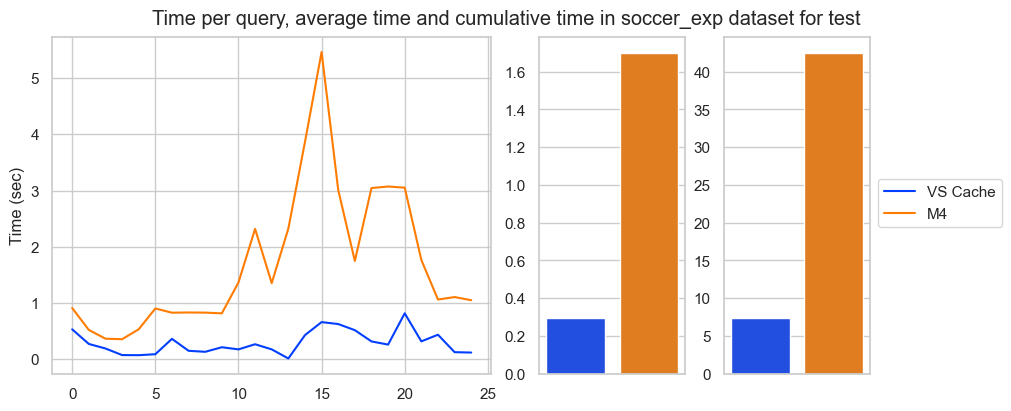

/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_25475/3071631948.py:67: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.2)  # Adjust the bottom margin to make space for the legend


<Figure size 640x480 with 0 Axes>

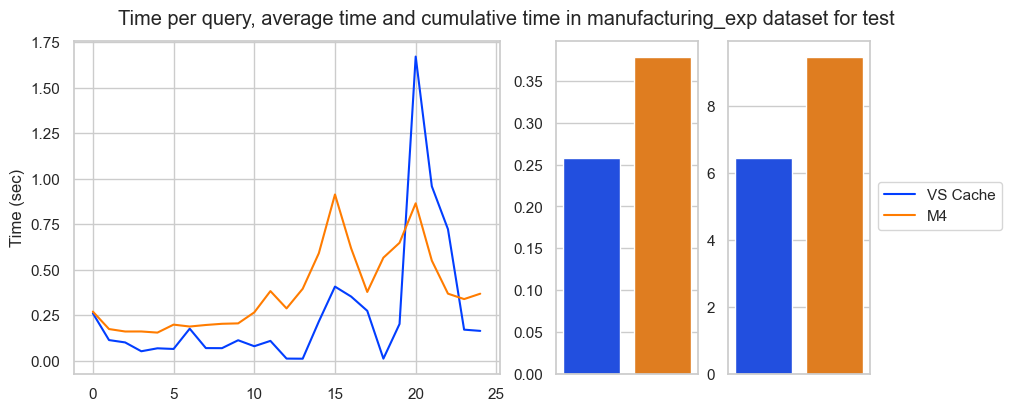

/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_25475/3071631948.py:67: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.2)  # Adjust the bottom margin to make space for the legend


<Figure size 640x480 with 0 Axes>

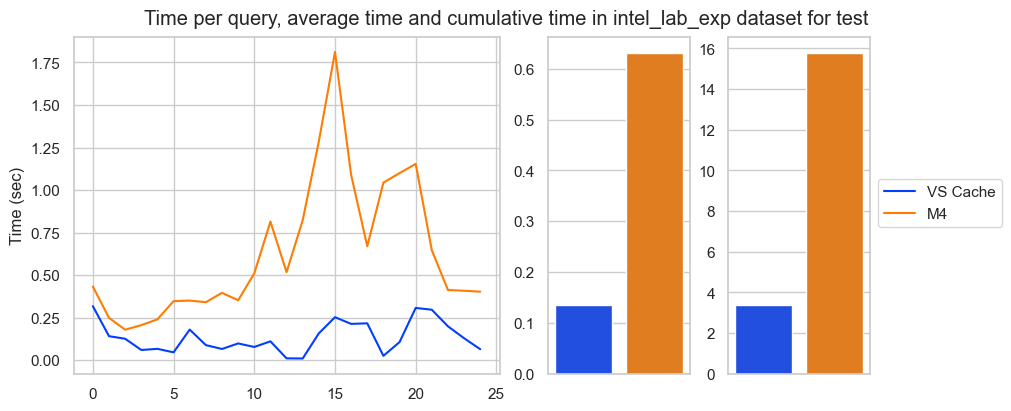

In [296]:
j = 0
k = 0
for i in range(0, len(dfs), len(labels)):
    if(len(labels) == 3):
        plot_time_all(dfs[i : i + 3], names[j % len(names)], exp_name[k])
        j +=1
    if(len(labels) == 2):
        plot_time(dfs[i : i + 2], names[j % len(names)], exp_name[k])
        j +=1
    if(j % len(names) == 0): k += 1

In [262]:
j = 0
k = 0
for i in range(0, len(dfs), 3):
    if(len(labels) == 3):
        plot_memory(dfs[i : i + 3], names[j % 3], exp_name[k])
        j +=1
        if(j % 3 == 0): k += 1

In [219]:
j = 0
k = 0
sz = len(labels)
for i in range(0, len(dfs), sz):
    if(sz == 3):
        plot_compaction(dfs[i : i + sz], names[j % sz], exp_name[k])
        j +=1
        if(j % sz == 0): k += 1
        

<Figure size 640x480 with 0 Axes>

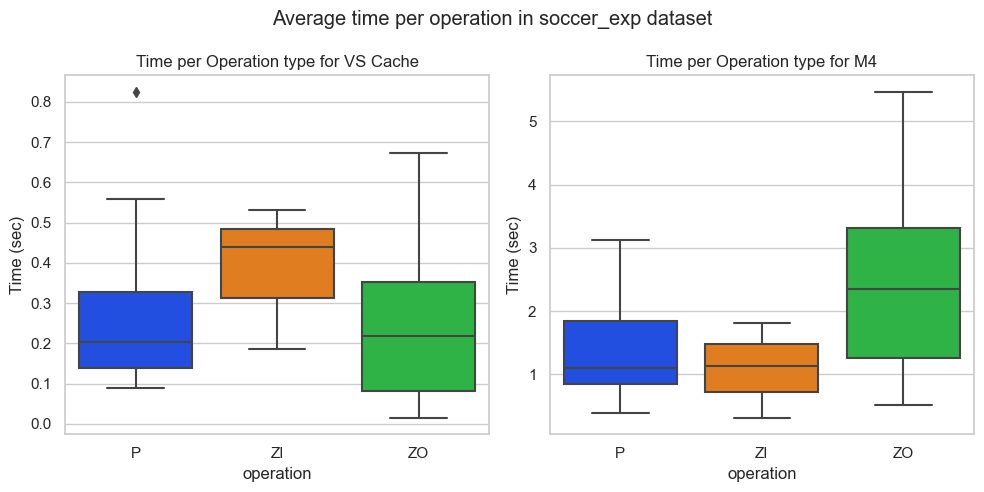

<Figure size 640x480 with 0 Axes>

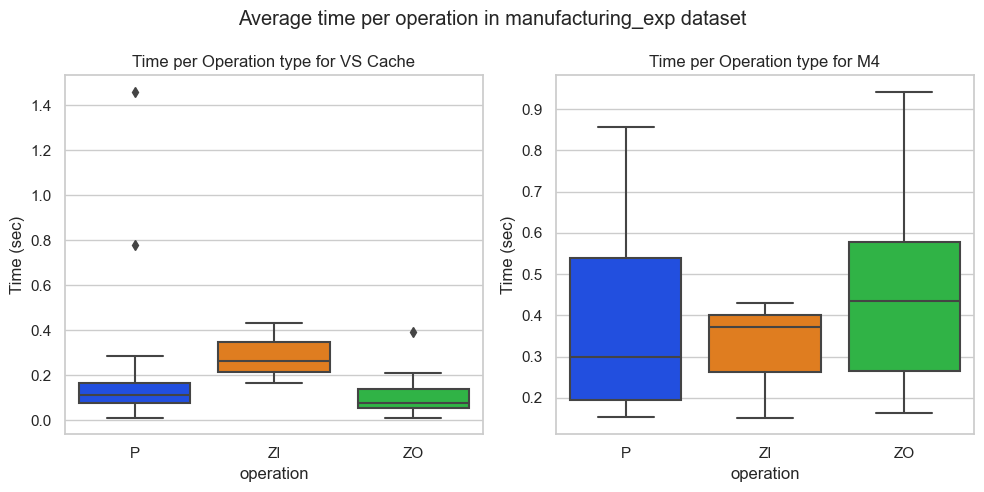

<Figure size 640x480 with 0 Axes>

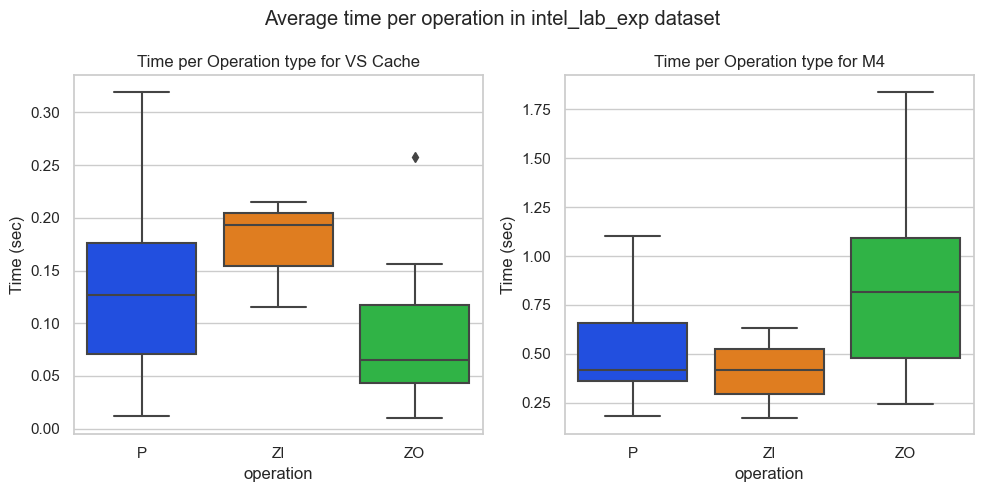

In [220]:
j = 0
k = 0
for i in range(0, len(dfs), len(labels)):
    if(len(labels) == 3):
        plot_time_per_operation(dfs[i : i + 3], names[j % len(names)], exp_name[k])
        j +=1
    if(len(labels) == 2):
        plot_time_per_operation(dfs[i : i + 2], names[j % len(names)], exp_name[k])
        j +=1
    if(j % len(names) == 0): k += 1

In [221]:
from skimage import io, color
from skimage.metrics import structural_similarity as compare_ssim
import cairo

def plot(df, measure, name, width, height, queryFrom, queryTo):
    # Define the surface and the context
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, width, height)
    ctx = cairo.Context(surface)
    
    ctx.set_antialias(cairo.Antialias.NONE)
    
    # Clear the background (white)
    ctx.set_source_rgb(1, 1, 1)
    ctx.paint()
    
    # Transform coordinate system so that (0,0) is the bottom left
    ctx.translate(0, height)
    ctx.scale(1, -1)
    
    # Plot the line (black)
    ctx.set_source_rgb(0, 0, 0)  # color
    ctx.set_line_width(1)  # line width
    
    pixelInterval = (queryTo - queryFrom) // width
    
    # Move to the first point
    ctx.move_to(
        np.floor((df['timestamp'].iloc[0] - queryFrom) / pixelInterval), 
        np.floor(height * ((df[measure].iloc[0] - df[measure].min()) / (df[measure].max() - df[measure].min())))
    )

    # Add lines to subsequent points
    for i in range(1, len(df)):
        ctx.line_to(
            np.floor((df['timestamp'].iloc[i] - queryFrom) / pixelInterval), 
            np.floor(height * ((df[measure].iloc[i] - df[measure].min()) / (df[measure].max() - df[measure].min())))
        )

    ctx.stroke()  # Apply the stroke
    
    # Save to a file
    surface.write_to_png(name + '.png')

    
    
def calculate_ssim(image_file1, image_file2, width, height):
    # Read the two images
    image1 = io.imread(image_file1)
    image2 = io.imread(image_file2)
    # Remove the alpha channel if present
    if image1.shape[2] == 4:
        image1 = image1[:, :, :3]
    if image2.shape[2] == 4:
        image2 = image2[:, :, :3]
    
    image1_gray = color.rgb2gray(image1)
    image2_gray = color.rgb2gray(image2)
    
    (score, _) = compare_ssim(image1_gray, image2_gray, full=True)
    # print(f"SSIM between {image_file1} and {image_file2}: {ssim_index:.4f}")
    diff = image1_gray - image2_gray
    # Search for all pixels that are different 
    # Type is <class 'numpy.ndarray'>, you can optionally convert to a list
    coords = np.argwhere(diff != 0)
    coords = coords.tolist() 
    return score, len(coords)/(width*height)


def get_mean_error(s, measures):
    a = (s.split("="))
    errs = []
    for l in a:
        if ("," in l):
            errs.append(float(l.split(",")[0]))
    errs.append(float(a[-1].split(",")[0][:-1]))
    return np.mean(errs)
    
    
def plot_indexes(df1, df2, data, name, exp):

    fig, axs = plt.subplots(1, 1, figsize=(10, 8))

    tti_path1 = os.path.join(data, name, "run_0", "ttiMinMaxResults")
    # tti_path2 = os.path.join(data, name, "run_0", "ttiMinMaxResults")
    
    raw_path = os.path.join(data, name, "run_0", "rawResults")
    m4_path = os.path.join(data, name, "run_0", "m4Results")

    tti_query_0 = os.path.join(data, name, "run_0", "ttiMinMaxResults", "query_0")
    sql_query_0 = os.path.join(data, name, "run_0", "m4Results", "query_0")

    meassure_files = os.listdir(tti_query_0)
    measures = [x.replace(".csv", "") for x in meassure_files]
    queries = os.listdir(results_paths[0])
    all_ssim = [] 
    all_diffs = [] 
    errors = []
    errors1 = df1['Error'].apply(get_mean_error, args=([measures]))
    #errors2 = df2['Error'].apply(get_mean_error, args=([measures]))

    for i in range(len(df1)):
        q = f"query_{i}"
        j = 0
        ssim1 = 0
        ssim2 = 0
        diffs1 = 0
        diffs2 = 0
        for m in meassure_files:
            path_tti1 = os.path.join(tti_path1, q)
            #path_tti2 = os.path.join(tti_path2, q)
            
            #path_raw = os.path.join(raw_path, q)
            path_sql = os.path.join(m4_path, q)
            df_tti1 = pd.read_csv(os.path.join(path_tti1, m))
            #df_tti2 = pd.read_csv(os.path.join(path_tti2, m))
            df_m4 = pd.read_csv(os.path.join(path_sql, m))
            #df_raw = pd.read_csv(os.path.join(path_raw, m))
            width = int(df1['width'][0])
            height = int(df1['height'][0])
            queryFrom = int(df1['from'][i])
            queryTo = int(df1['to'][i])
            plot(df_tti1, measures[j], f"plots/{q}-{measures[j]}-tti1",width,height, queryFrom, queryTo)
            #plot(df_tti2, measures[j], f"plots/{q}-{measures[j]}-tti2",width,height, queryFrom, queryTo)   
            plot(df_m4, measures[j], f"plots/{q}-{measures[j]}-m4", width, height, queryFrom, queryTo)
            score1, diff1 = calculate_ssim(f"plots/{q}-{measures[j]}-tti1.png", f"plots/{q}-{measures[j]}-m4.png", width, height)
            #score2, diff2 = calculate_ssim(f"plots/{q}-{measures[j]}-tti2.png", f"plots/{q}-{measures[j]}-m4.png", width, height)
            #print(f"SSIM for query {i}: {score} {diff}")
            ssim1 += score1
            #ssim2 += score2
            diffs1 += diff1
            #diffs2 += diff2
            # os.remove("tti.png")
            # os.remove("raw.png")
            j+=1  
        avg_ssim1 = ssim1 / len(measures)
        #avg_ssim2 = ssim2 / len(measures)
        avg_diff1 = diffs1 / len(measures)
        #avg_diff2 = diffs2 / len(measures)
        all_ssim.append(avg_ssim1)
        all_diffs.append(avg_diff1)
        # all_ssim.append([avg_ssim1, avg_ssim2])
        # all_diffs.append([avg_diff1, avg_diff2])
        
    fig.suptitle(f"SSIM: {name} dataset for {exp}", fontsize=14, fontweight='bold')

    axs.plot(all_ssim, label="SSIM", linewidth=2.5)
    axs.plot(errors1, label="Max Error", linewidth=2.5)
    #axs.plot(errors2, label=f"MAX ERROR Min Max", linewidth=2.5)

    # Remove spines
    sns.despine()

    # Set x-axis ticks
    axs.set_xticks(range(len(df1)))
    # Set x-axis tick labels as 'query_{q}'
    axs.set_xticklabels([f'{i}:{dfs_all[0].operation[i]}' for i in range(len(df1))], rotation=45)

    axs.plot(all_diffs, label="Difference", linewidth=2.5)

    # Legend adjustments
    handles, labels = axs.get_legend_handles_labels()
    custom_legend = plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

    plt.savefig(f"ssims/{exp}-{name}.png")
    plt.show()

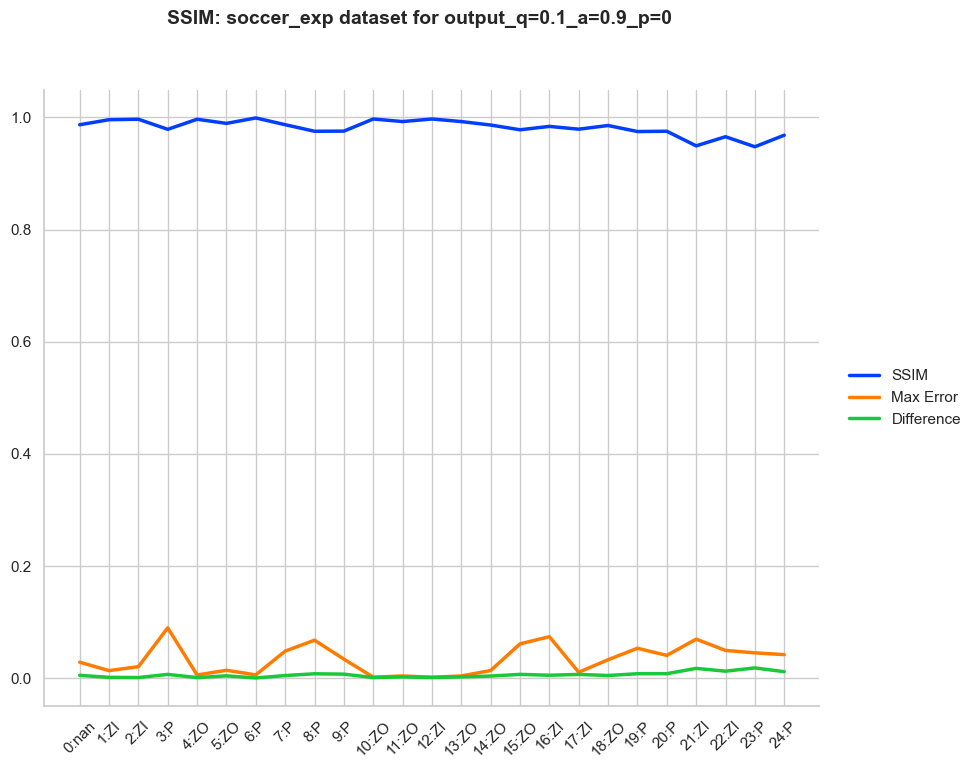

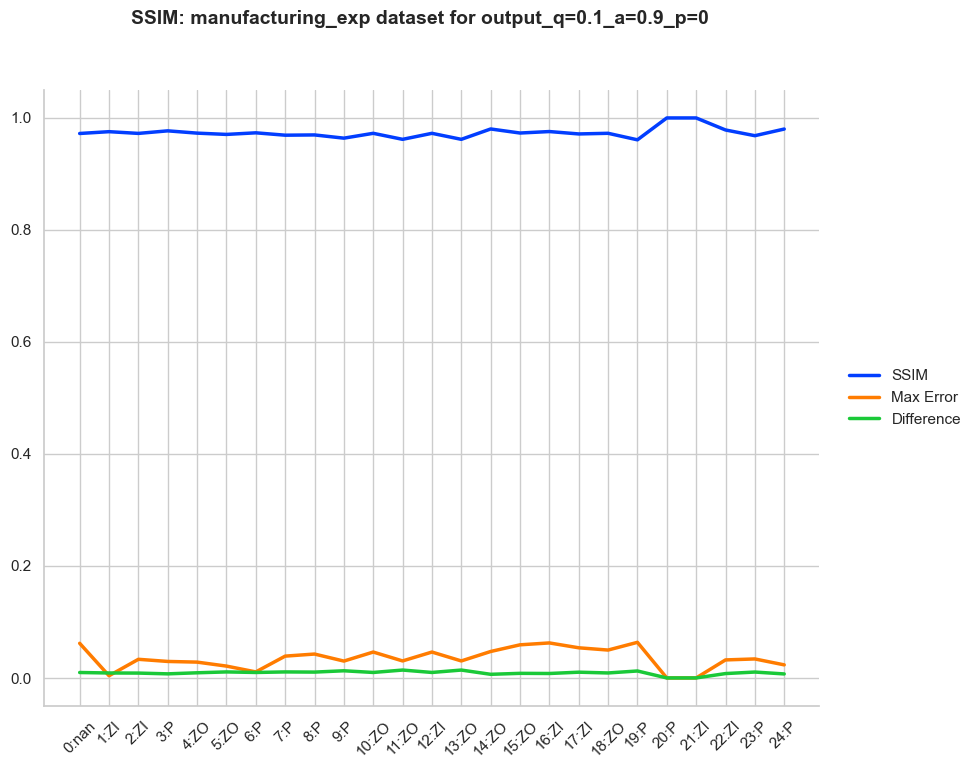

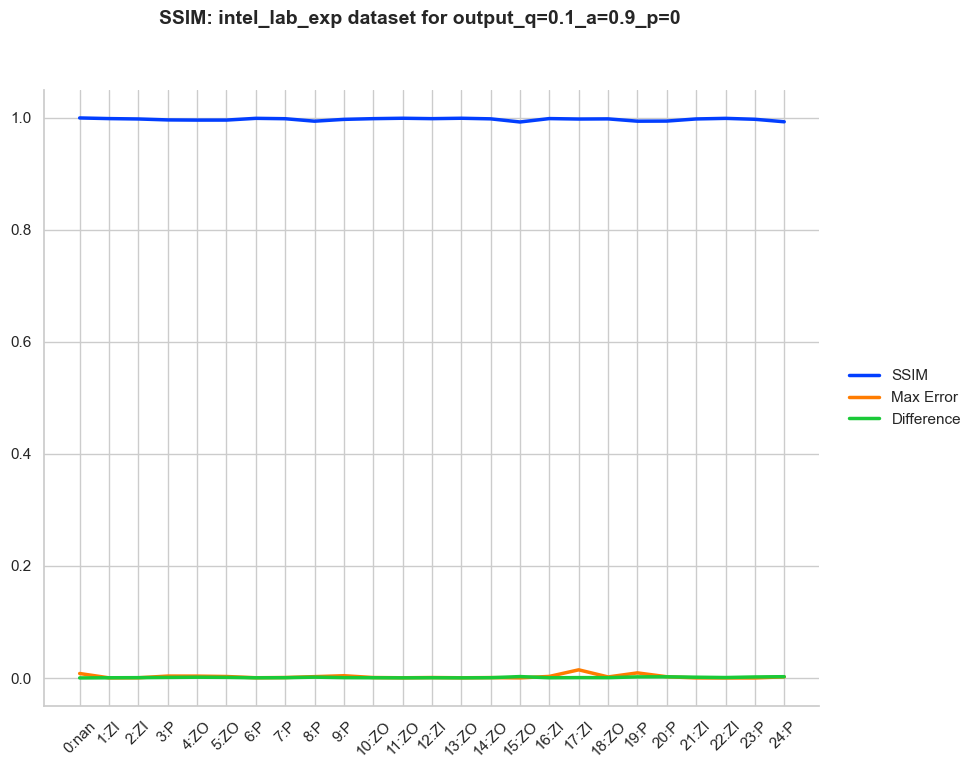

In [279]:
j = 0
k = 0
sz = len(labels)
for i in range(0, len(dfs), sz):
    plot_indexes(dfs[i], dfs[i + 1], data[k], names[j % len(names)], exps[k])
    j +=1
    if(j % len(names) == 0): k += 1